# Blockhouse Work Trial - Question 1

## Overview
This notebook builds a model for the temporary impact function $g_t(x)$, which measures the amount of slippage of executing a market order of size $x$, relative to the mid-price at the time of execution. The model is based on the given limit order book snapshots across 21 days for 3 stocks: FROG, SOUN, and CRWV.

We'll use:
- One snapshot per minute  
- $N=390$ minutes in each trading day
- Given $21$ files per ticker => $390*21\approx8190$ snapshots per stock
- Given $3$ tickers, => $3*8190\approx24570$ snapshots in total

## Setup and Imports

In [17]:
%pip install matplotlib

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Load and Concatenate Data for each Ticker

In [2]:
PROJECT_ROOT = Path.cwd().parent
RAW_DIR = PROJECT_ROOT / "data" / "raw"

def load_all(ticker):
    csv_files = list(RAW_DIR.glob(f"{ticker}/*{ticker}_2025-*.csv"))
    print(len(csv_files), "files found for", ticker)
    df_list = []
    for file in csv_files:
        try:
            df_list.append(pd.read_csv(file))
        except Exception as e:
            print(f"Error reading {file}: {e}")
    return pd.concat(df_list, ignore_index=True)

frog_df = load_all("FROG")
soun_df = load_all("SOUN")
crwv_df = load_all("CRWV")

# df.to_csv(PROJECT_ROOT / "data" / "processed" / "orderbook_combined.csv", index=False)



21 files found for FROG
21 files found for SOUN
21 files found for CRWV


## Preprocess to Extract One Snapshot for each Minute

We'll round each timestamp down to the nearest minute and retain the last limit order book update in each minute.

In [3]:
# Parse the timestamps in ISO8601 format
frog_df["ts_event"] = pd.to_datetime(frog_df["ts_event"], format="ISO8601", errors="coerce")
soun_df["ts_event"] = pd.to_datetime(soun_df["ts_event"], format="ISO8601", errors="coerce")
crwv_df["ts_event"] = pd.to_datetime(crwv_df["ts_event"], format="ISO8601", errors="coerce")

In [4]:
def extract_snapshots(df):
    df["ts_event"] = pd.to_datetime(df["ts_event"])
    df["minute"] = df["ts_event"].dt.floor("min")
    return df.groupby("minute").last().reset_index()

frog_min = extract_snapshots(frog_df)
soun_min = extract_snapshots(soun_df)
crwv_min = extract_snapshots(crwv_df)

In [5]:
for df in [frog_min, soun_min, crwv_min]:
    print(f"Number of unique snapshots in {df['minute'].name}: {df['minute'].nunique()}")

Number of unique snapshots in minute: 8162
Number of unique snapshots in minute: 8190
Number of unique snapshots in minute: 8189


In [6]:
frog_min.loc[:,["minute", "ask_px_00", "ask_sz_00", "bid_px_00", "bid_sz_00"]].head()

,minute,ask_px_00,ask_sz_00,bid_px_00,bid_sz_00
0,2025-04-03 13:30:00+00:00,31.50,225,31.07,300
1,2025-04-03 13:31:00+00:00,31.87,220,31.41,500
2,2025-04-03 13:32:00+00:00,31.87,220,31.41,500
3,2025-04-03 13:33:00+00:00,31.87,223,31.41,500
4,2025-04-03 13:34:00+00:00,31.87,3,31.41,400


### Define Slippage

The slippage is:

$$g_t(x) = \text{Actual Price} - \text{Expected Price} = \frac{\text{Cost}(x)}{x} - \text{Mid}_t = \frac{\sum_{i=0}^k p_i \cdot \min(q_i, r_i)}{x} - \frac{\text{best bid} + \text{best ask}}{2}$$

Where:
- $p_i$: ask price at level $i$
- $q_i$: size at level $i$
- $r_i$: remaining quantity to fill

### Compute Temporary Impact (Slippage Incurred While Trading on a Certain Line in LOB)
We simulate orders to be bought of size $x = 1$ to $x = \text{max\_qty}$ using a given row of the 10-level ask side of the real limit order book. 

In [7]:
def compute_gtx(row, max_qty=500):
    """
    Compute the temporary impact function g_t(x) for a given row of the limit order book snapshot.

    Parameters:
        row (pd.Series): A Series representing a single snapshot.
        max_qty (int): The maximum order size to simulate. Defaults to 500.

    Returns:
        slippage (list): A list of slippage values for order sizes from 1 to max_qty.
    """
    # Get all the ask prices and sizes
    ask_px = []
    ask_sz = []
    for i in range(10):
        ask_px.append(row[f"ask_px_0{i}"])
        ask_sz.append(row[f"ask_sz_0{i}"])

    # Get the best bid price
    best_bid = row["bid_px_00"]
    
    # Calculate the mid price
    mid_price = (best_bid + ask_px[0]) / 2

    # Simulate market orders of size x = 1 to x = max_qty
    slippage = []
    for order_size in range(1, max_qty + 1):
        quantity_remaining = order_size
        total_cost = 0

        # Iterate through the ask (price) levels
        for price, size in zip(ask_px, ask_sz):
            # Determine how much we can take from this level
            quantity_to_take = min(quantity_remaining, size)
            total_cost += price * quantity_to_take
            quantity_remaining -= quantity_to_take

            # If we've filled the order, break
            if quantity_remaining <= 0:
                break

        # If there isn't enough liquidity in the visible order book to fill the order, let's just skip this order size. We only want to return a defined slippage when the full order can be filled using the known data, for accuracy.
        if quantity_remaining > 0:
            slippage.append(np.nan)
        else:
            # Calculate the slippage, as defined above, for this order size
            slippage.append(total_cost / order_size - mid_price)

    return slippage

### Empirically Estimate $g_t(x)$ Using All Snapshots

We'll compute $g_t(x)$ for simulated orders across ~8,000 snapshots for each stock. Let's stick with the default maximum of 500 orders.

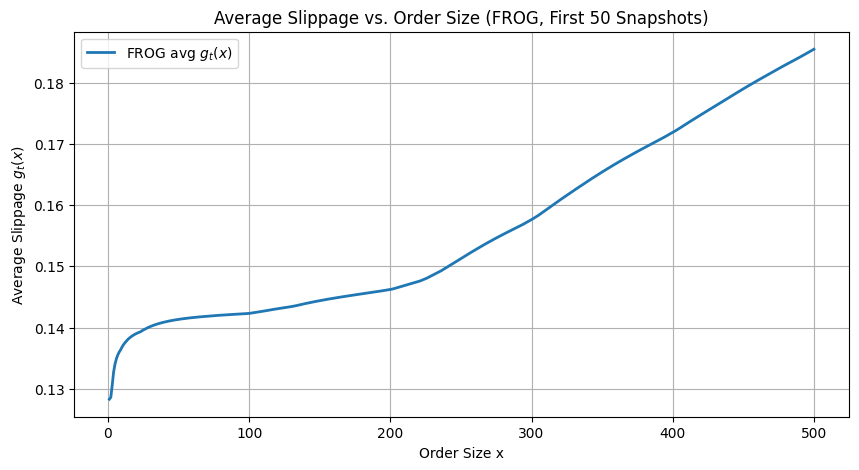

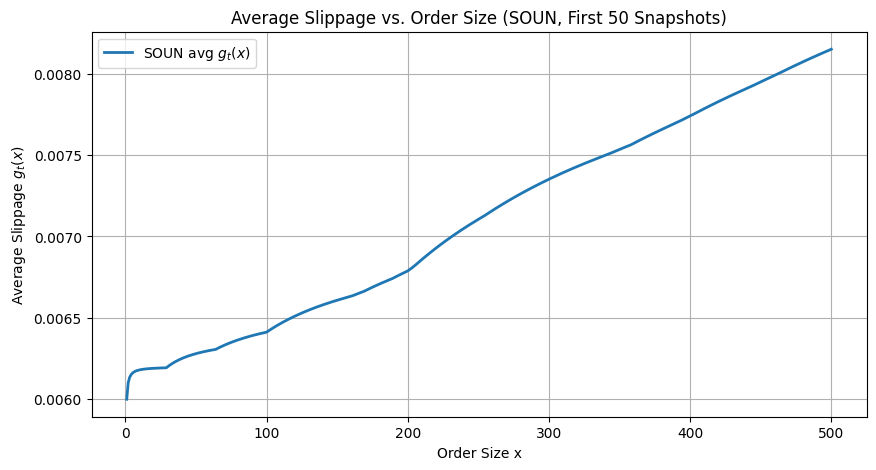

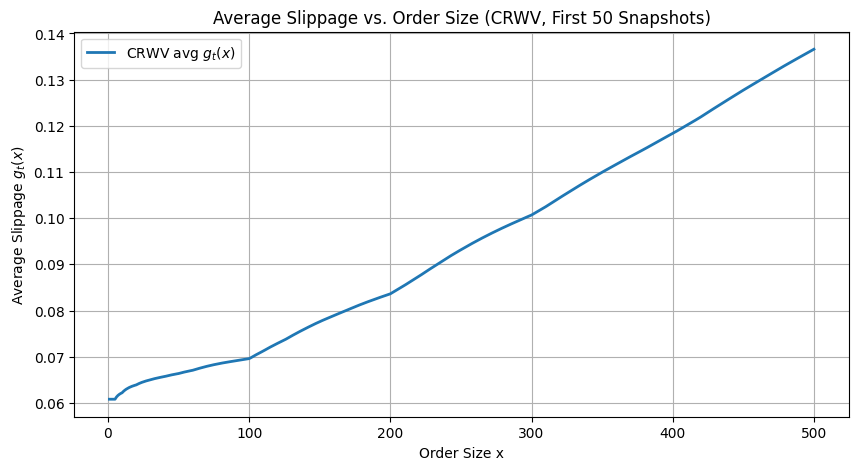

In [29]:
# Compute and plot g_t(x) for the first `num_snapshots` snapshots of each stock, plotting each stock separately
num_snapshots = 50
max_qty = 500

for name, df in [("FROG", frog_min), ("SOUN", soun_min), ("CRWV", crwv_min)]:
    gtx_matrix = []
    for i in range(min(num_snapshots, len(df))):
        row = df.iloc[i]
        gtx = compute_gtx(row, max_qty=max_qty)
        gtx_matrix.append(gtx)
    gtx_matrix = np.array(gtx_matrix)
    avg_gtx = np.nanmean(gtx_matrix, axis=0)
    x_vals = np.arange(1, max_qty + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, avg_gtx, label=f"{name} avg $g_t(x)$", linewidth=2)
    plt.xlabel("Order Size x")
    plt.ylabel("Average Slippage $g_t(x)$")
    plt.title(f"Average Slippage vs. Order Size ({name}, First {num_snapshots} Snapshots)")
    plt.legend()
    plt.grid(True)
    plt.show()